In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cuda


In [15]:
class GridEnvironment:
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows = rows
        self.cols = cols
        self.start_state = (0, 0)
        self.goal_state = (rows - 1, cols - 1)
        self.state = self.start_state

        self.state_dim = 2
        self.action_dim = 4

        # Actions: 0=up, 1=down, 2=left, 3=right
        self.action_map = {
            0: (-1, 0),
            1: (1, 0),
            2: (0, -1),
            3: (0, 1)
        }

    def reset(self) -> torch.Tensor:
        # Reset to start position
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        # Normalize coordinates to [0, 1]
        norm_row = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        return torch.tensor([norm_row, norm_col], dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        # Move agent based on action
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True

        dr, dc = self.action_map[action]
        r, c = self.state
        nr, nc = r + dr, c + dc

        reward = -0.1  # default step penalty

        # Check if move is valid
        if not (0 <= nr < self.rows and 0 <= nc < self.cols):
            nr, nc = r, c
            reward = -1.0  # penalty for hitting wall

        self.state = (nr, nc)
        done = self.state == self.goal_state
        if done:
            reward = 10.0  # reward for reaching goal

        return self._get_state_tensor(self.state), reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

    def get_state_dimension(self) -> int:
        return self.state_dim


In [16]:
custom_env = GridEnvironment(rows=10, cols=10)
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
start_state_tensor = custom_env.reset()
print(f"Example state tensor for (0,0): {start_state_tensor}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Example state tensor for (0,0): tensor([0., 0.], device='cuda:0')


In [17]:
# PPO Actor network
class PolicyNetwork(nn.Module):
    def __init__(self, n_observations: int, n_actions: int):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        # Preprocess input
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
            x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Forward pass
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        logits = self.layer3(x)

        return Categorical(logits=logits)


In [18]:
# PPO Critic network
class ValueNetwork(nn.Module):
    def __init__(self, n_observations: int):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Preprocess input
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
            x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Forward pass
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [19]:
# Compute GAE (Generalized Advantage Estimation)
def compute_gae(rewards: torch.Tensor,
                values: torch.Tensor,
                next_values: torch.Tensor,
                dones: torch.Tensor,
                gamma: float,
                lambda_gae: float,
                standardize: bool = True) -> torch.Tensor:

    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0

    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    if standardize:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return advantages


In [20]:
# PPO update loop
def update_ppo(actor: PolicyNetwork,
               critic: ValueNetwork,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer,
               states: torch.Tensor,
               actions: torch.Tensor,
               log_probs_old: torch.Tensor,
               advantages: torch.Tensor,
               returns_to_go: torch.Tensor,
               ppo_epochs: int,
               ppo_clip_epsilon: float,
               value_loss_coeff: float,
               entropy_coeff: float) -> Tuple[float, float, float]:

    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_entropy = 0.0

    advantages = advantages.detach()
    log_probs_old = log_probs_old.detach()
    returns_to_go = returns_to_go.detach()

    for _ in range(ppo_epochs):
        # Actor update
        dist = actor(states)
        log_probs_new = dist.log_prob(actions)
        entropy = dist.entropy().mean()

        ratio = torch.exp(log_probs_new - log_probs_old)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - ppo_clip_epsilon, 1 + ppo_clip_epsilon) * advantages
        policy_loss = -torch.min(surr1, surr2).mean() - entropy_coeff * entropy

        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()

        # Critic update
        values = critic(states).squeeze()
        value_loss = F.mse_loss(values, returns_to_go)

        critic_optimizer.zero_grad()
        (value_loss_coeff * value_loss).backward()
        critic_optimizer.step()

        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
        total_entropy += entropy.item()

    return (total_policy_loss / ppo_epochs,
            total_value_loss / ppo_epochs,
            total_entropy / ppo_epochs)


In [21]:
# PPO hyperparameters for GridWorld
GAMMA_PPO = 0.99
GAE_LAMBDA_PPO = 0.95
PPO_CLIP_EPSILON = 0.2
ACTOR_LR = 3e-4
CRITIC_LR_PPO = 1e-3
PPO_EPOCHS = 10
VALUE_LOSS_COEFF = 0.5
ENTROPY_COEFF = 0.01
STANDARDIZE_ADV_PPO = True

NUM_ITERATIONS_PPO = 150
STEPS_PER_ITERATION_PPO = 1000
MAX_STEPS_PER_EPISODE_PPO = 200


In [22]:
# Set up environment and networks
env = GridEnvironment(rows=10, cols=10)
n_obs = env.get_state_dimension()
n_act = env.get_action_space_size()

actor = PolicyNetwork(n_obs, n_act).to(device)
critic = ValueNetwork(n_obs).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR_PPO)

# Logging
ppo_rewards = []
ppo_avg_lens = []
ppo_policy_losses = []
ppo_value_losses = []
ppo_entropies = []


In [30]:
print("Starting PPO Training...")

for iteration in range(NUM_ITERATIONS_PPO):
    # Rollout phase
    states, actions, log_probs_old = [], [], []
    rewards, values, dones = [], [], []
    ep_rewards, ep_lengths = [], []
    steps = 0

    while steps < STEPS_PER_ITERATION_PPO:
        state = env.reset()
        ep_reward, ep_len, done = 0.0, 0, False

        for _ in range(MAX_STEPS_PER_EPISODE_PPO):
            with torch.no_grad():
                dist = actor(state)
                value = critic(state).squeeze()
                action = dist.sample()
                log_prob = dist.log_prob(action)

            next_state, reward, done = env.step(action.item())

            # Store transition
            states.append(state)
            actions.append(action.item())
            log_probs_old.append(log_prob)
            values.append(value)
            rewards.append(reward)
            dones.append(float(done))

            state = next_state
            ep_reward += reward
            steps += 1
            ep_len += 1

            if done or steps >= STEPS_PER_ITERATION_PPO:
                ep_rewards.append(ep_reward)
                ep_lengths.append(ep_len)
                break

    # Bootstrap next values for GAE
    next_values = []
    with torch.no_grad():
        for i in range(len(states)):
            if dones[i] > 0.5:
                next_values.append(torch.tensor(0.0, device=device))
            elif i == len(states) - 1:
                next_s = env.step(actions[i])[0]
                next_values.append(critic(next_s).squeeze().to(device))
            else:
                next_values.append(values[i + 1])

    # Convert to tensors
    states = torch.stack(states).to(device)
    actions = torch.tensor(actions, dtype=torch.long, device=device)
    log_probs_old = torch.stack(log_probs_old).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    values = torch.stack(values).to(device)
    next_values = torch.stack(next_values).to(device)
    dones = torch.tensor(dones, dtype=torch.float32, device=device)

    # GAE + Returns
    adv = compute_gae(rewards, values, next_values, dones, GAMMA_PPO, GAE_LAMBDA_PPO, STANDARDIZE_ADV_PPO)
    returns = adv + values

    # PPO update
    p_loss, v_loss, entropy = update_ppo(
        actor, critic, actor_optimizer, critic_optimizer,
        states, actions, log_probs_old, adv, returns,
        PPO_EPOCHS, PPO_CLIP_EPSILON, VALUE_LOSS_COEFF, ENTROPY_COEFF
    )

    # Log
    ppo_rewards.append(np.mean(ep_rewards))
    ppo_avg_lens.append(np.mean(ep_lengths))
    ppo_policy_losses.append(p_loss)
    ppo_value_losses.append(v_loss)
    ppo_entropies.append(entropy)

    if (iteration + 1) % 10 == 0:
        print(f"Iter {iteration+1}/{NUM_ITERATIONS_PPO} | R: {ppo_rewards[-1]:.2f} | Len: {ppo_avg_lens[-1]:.1f} | π_loss: {p_loss:.4f} | V_loss: {v_loss:.4f} | H: {entropy:.4f}")

print("Training Complete.")


Starting PPO Training...
Iter 10/150 | R: -12.20 | Len: 120.0 | π_loss: -0.0266 | V_loss: 0.9789 | H: 1.3738
Iter 20/150 | R: -5.47 | Len: 90.9 | π_loss: -0.0130 | V_loss: 0.9811 | H: 1.3561
Iter 30/150 | R: -9.63 | Len: 111.1 | π_loss: -0.0165 | V_loss: 0.9644 | H: 1.3658
Iter 40/150 | R: -6.31 | Len: 100.0 | π_loss: -0.0192 | V_loss: 0.9866 | H: 1.3667
Iter 50/150 | R: -2.04 | Len: 76.9 | π_loss: -0.0106 | V_loss: 0.9434 | H: 1.3507
Iter 60/150 | R: -7.83 | Len: 111.1 | π_loss: -0.0153 | V_loss: 0.9965 | H: 1.3604
Iter 70/150 | R: -8.36 | Len: 100.0 | π_loss: -0.0215 | V_loss: 1.0018 | H: 1.3630
Iter 80/150 | R: -8.03 | Len: 111.1 | π_loss: -0.0200 | V_loss: 0.9846 | H: 1.3632
Iter 90/150 | R: -1.94 | Len: 72.7 | π_loss: -0.0101 | V_loss: 0.9417 | H: 1.3555
Iter 100/150 | R: -2.97 | Len: 83.3 | π_loss: -0.0176 | V_loss: 0.9764 | H: 1.3635
Iter 110/150 | R: -0.35 | Len: 58.8 | π_loss: -0.0124 | V_loss: 0.9799 | H: 1.3488
Iter 120/150 | R: -1.14 | Len: 66.7 | π_loss: -0.0060 | V_loss: 

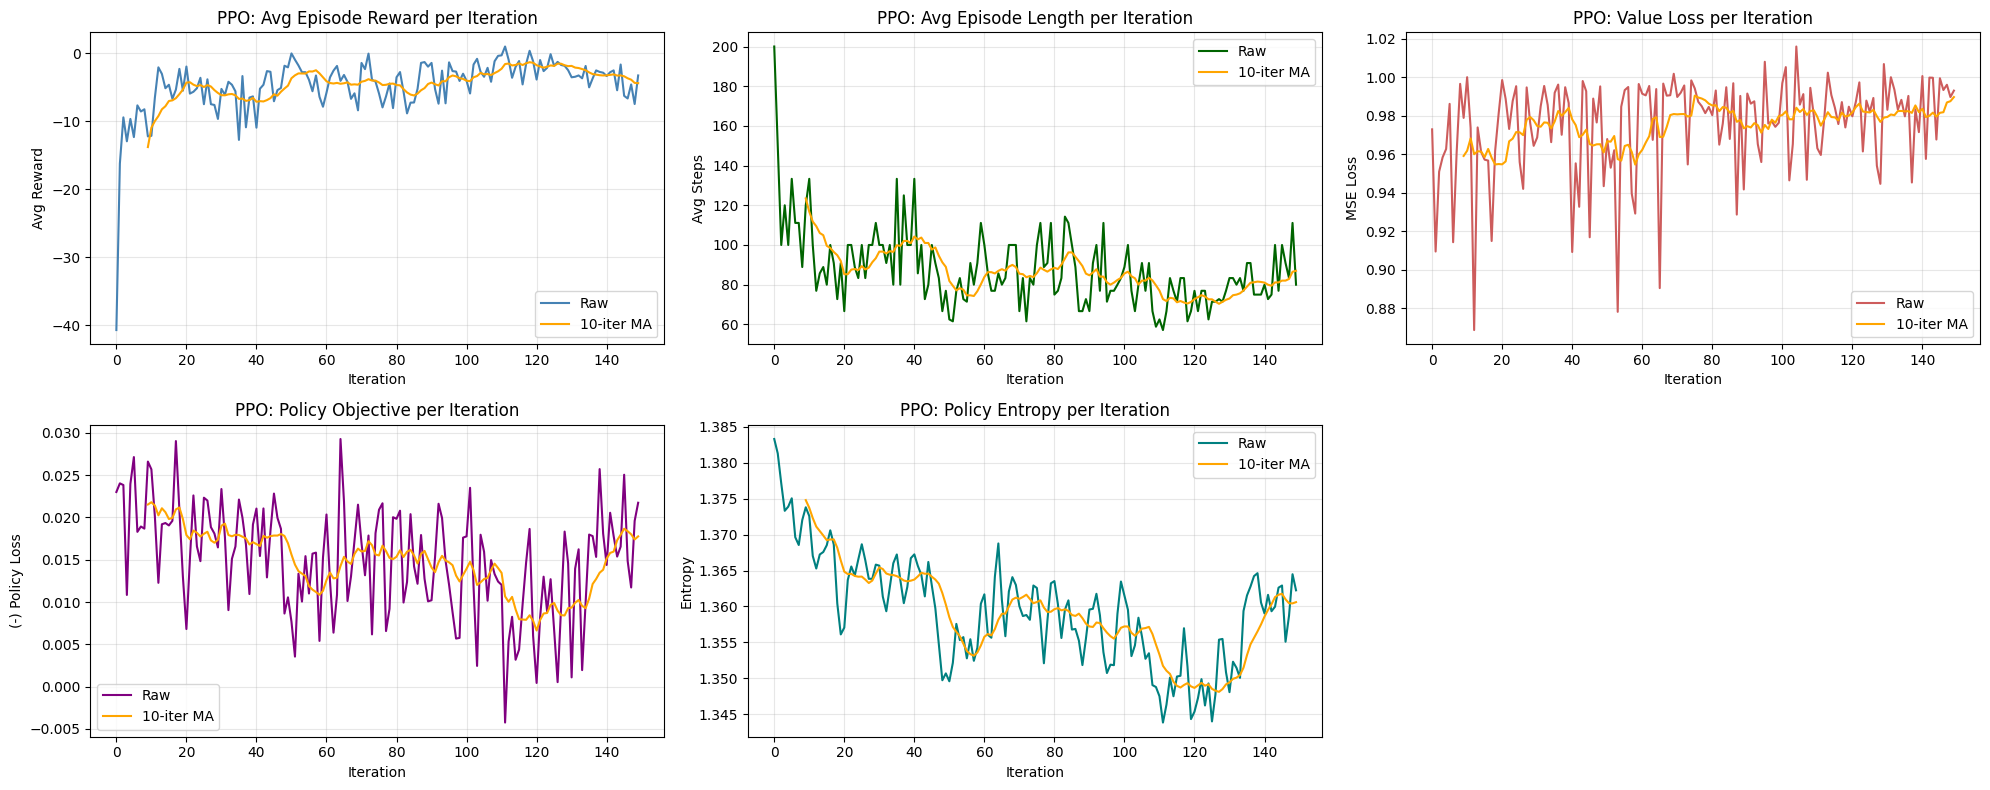

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))

# --- 1. Average Episode Rewards per Iteration ---
plt.subplot(2, 3, 1)
valid_rewards_ppo = [r for r in ppo_rewards if not np.isnan(r)]
valid_indices_ppo = [i for i, r in enumerate(ppo_rewards) if not np.isnan(r)]
plt.plot(valid_indices_ppo, valid_rewards_ppo, label='Raw', color='steelblue')
if len(valid_rewards_ppo) >= 10:
    rewards_ma_ppo = np.convolve(valid_rewards_ppo, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_ppo[9:], rewards_ma_ppo, label='10-iter MA', color='orange')
plt.title('PPO: Avg Episode Reward per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid(alpha=0.3)
plt.legend()

# --- 2. Average Episode Length per Iteration ---
plt.subplot(2, 3, 2)
valid_lens_ppo = [l for l in ppo_avg_lens if not np.isnan(l)]
valid_indices_len_ppo = [i for i, l in enumerate(ppo_avg_lens) if not np.isnan(l)]
plt.plot(valid_indices_len_ppo, valid_lens_ppo, label='Raw', color='darkgreen')
if len(valid_lens_ppo) >= 10:
    lens_ma_ppo = np.convolve(valid_lens_ppo, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_len_ppo[9:], lens_ma_ppo, label='10-iter MA', color='orange')
plt.title('PPO: Avg Episode Length per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Steps')
plt.grid(alpha=0.3)
plt.legend()

# --- 3. Critic (Value) Loss ---
plt.subplot(2, 3, 3)
plt.plot(ppo_value_losses, label='Raw', color='indianred')
if len(ppo_value_losses) >= 10:
    vloss_ma_ppo = np.convolve(ppo_value_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(vloss_ma_ppo)) + 9, vloss_ma_ppo, label='10-iter MA', color='orange')
plt.title('PPO: Value Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3)
plt.legend()

# --- 4. Actor (Policy) Loss (plotted as -loss for objective improvement) ---
plt.subplot(2, 3, 4)
neg_policy_loss = [-l for l in ppo_policy_losses]
plt.plot(neg_policy_loss, label='Raw', color='purple')
if len(ppo_policy_losses) >= 10:
    ploss_ma_ppo = np.convolve(neg_policy_loss, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(ploss_ma_ppo)) + 9, ploss_ma_ppo, label='10-iter MA', color='orange')
plt.title('PPO: Policy Objective per Iteration')
plt.xlabel('Iteration')
plt.ylabel('(-) Policy Loss')
plt.grid(alpha=0.3)
plt.legend()

# --- 5. Entropy per Iteration ---
plt.subplot(2, 3, 5)
plt.plot(ppo_entropies, label='Raw', color='teal')
if len(ppo_entropies) >= 10:
    entropy_ma_ppo = np.convolve(ppo_entropies, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(entropy_ma_ppo)) + 9, entropy_ma_ppo, label='10-iter MA', color='orange')
plt.title('PPO: Policy Entropy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()
